25から、緯度経度の集計を追加した。

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test")
location = geolocator.geocode(u"nashville")

print(location.address)       #住所
print(location.latitude)      #緯度
print(location.longitude)     #経度
print(location.raw)           #ジオコーディングした結果の全ての情報

Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States
36.1622767
-86.7742984
{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}


In [61]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

from geopy.geocoders import Nominatim
# geolocator = Nominatim()

from geopy.extra.rate_limiter import RateLimiter
import time

In [62]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [63]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [64]:
train_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [65]:
test_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

In [66]:
train_df['state'].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [67]:
# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
test_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(test_df['region'], test_df['state'])]

In [68]:
def geo(X):
    # Geolocatorオブジェクトを作成
    geolocator = Nominatim(user_agent="gabikueh")

    # ユニークなregionを取得
    unique_regions = X['region'].unique()

    # 緯度経度の辞書を作成
    lat_lon_dict = {}

    for city in unique_regions:
        try:
            location = geolocator.geocode(city)
            if location:
                lat_lon_dict[city] = {'latitude': location.latitude, 'longitude': location.longitude}
                print(location.raw)  # ジオコーディングした結果の全ての情報
            else:
                lat_lon_dict[city] = {'latitude': None, 'longitude': None}
                print(f"Failed to geocode for city: {city}")
        except Exception as e:
            lat_lon_dict[city] = {'latitude': None, 'longitude': None}
            print(f"Error geocoding city: {city}. Error message: {e}")
        # time.sleep(2)  # 1秒待機

    # ユニークな地域の緯度経度を元のデータフレームにマージ
    geo_df = pd.DataFrame.from_dict(lat_lon_dict, orient='index').reset_index().rename(columns={'index': 'region'})
    X = X.merge(geo_df, on='region', how='left')

    return X

train_df = geo(train_df)
test_df = geo(test_df)

{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}
{'place_id': 299449022, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 188627, 'lat': '40.7944504', 'lon': '-77.8616386', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46200246531290373, 'addresstype': 'city', 'name': 'State College', 'display_name': 'State College, Centre County, Pennsylvania, United States', 'boundingbox': ['40.7683701', '40.8072297', '-77.8861677', '-77

{'place_id': 123718440, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 77823522, 'lat': '34.628508', 'lon': '-86.930048', 'class': 'highway', 'type': 'trunk', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Huntsville-Decatur Highway', 'display_name': 'Huntsville-Decatur Highway, Sweetwater, Decatur, Limestone County, Alabama, 35649, United States', 'boundingbox': ['34.6281857', '34.6288397', '-86.9445889', '-86.9157189']}
{'place_id': 361262224, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1128379, 'lat': '28.5421109', 'lon': '-81.3790304', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6305938364430198, 'addresstype': 'city', 'name': 'Orlando', 'display_name': 'Orlando, Orange County, Florida, United States', 'boundingbox': ['28.3480634', '28.6142830', '-81.5075377', '-81.22758

{'place_id': 299219018, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 7783199, 'lat': '46.56132435', 'lon': '-87.41048112721177', 'class': 'amenity', 'type': 'university', 'place_rank': 30, 'importance': 0.42173098883034005, 'addresstype': 'amenity', 'name': 'Northern Michigan University', 'display_name': 'Northern Michigan University, East Fair Avenue, Marquette, Marquette County, Michigan, 49855, United States', 'boundingbox': ['46.5551723', '46.5677273', '-87.4162346', '-87.3861668']}
{'place_id': 298358354, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 186761, 'lat': '44.0581728', 'lon': '-121.3153096', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.49505362854050977, 'addresstype': 'city', 'name': 'Bend', 'display_name': 'Bend, Deschutes County, Oregon, United States', 'boundingbox': ['43.9990630', '44.123

{'place_id': 298156059, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 112382, 'lat': '37.9577016', 'lon': '-121.2907796', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5518263511314941, 'addresstype': 'city', 'name': 'Stockton', 'display_name': 'Stockton, San Joaquin County, CAL Fire Southern Region, California, United States', 'boundingbox': ['37.8877470', '38.0583000', '-121.4197360', '-121.1840372']}
{'place_id': 298034842, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 182130, 'lat': '41.4996574', 'lon': '-81.6936772', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6460814677788097, 'addresstype': 'city', 'name': 'Cleveland', 'display_name': 'Cleveland, Cuyahoga County, Ohio, United States', 'boundingbox': ['41.3906280', '41.6044360', '-81.8790937', '-81.5327440']}
{'place_

{'place_id': 297995864, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 128653, 'lat': '41.5910323', 'lon': '-93.6046655', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5879068004079941, 'addresstype': 'city', 'name': 'Des Moines', 'display_name': 'Des Moines, Polk County, Iowa, United States', 'boundingbox': ['41.4796389', '41.6589106', '-93.7091411', '-93.4936911']}
{'place_id': 297986872, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119557, 'lat': '33.7489924', 'lon': '-84.3902644', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6908028207926616, 'addresstype': 'city', 'name': 'Atlanta', 'display_name': 'Atlanta, Fulton County, Georgia, United States', 'boundingbox': ['33.6478080', '33.8868230', '-84.5510680', '-84.2895600']}
{'place_id': 297907245, 'licence': 'Data © OpenSt

{'place_id': 299489310, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11000241, 'lat': '34.539984', 'lon': '-112.468812', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5190275667551049, 'addresstype': 'city', 'name': 'Prescott', 'display_name': 'Prescott, Yavapai County, Arizona, United States', 'boundingbox': ['34.5125262', '34.6799352', '-112.5299550', '-112.3760980']}
{'place_id': 362976765, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 130719, 'lat': '36.9903199', 'lon': '-86.4436018', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5164935180257069, 'addresstype': 'city', 'name': 'Bowling Green', 'display_name': 'Bowling Green, Warren County, Kentucky, 42101, United States', 'boundingbox': ['36.8988470', '37.0466520', '-86.5332070', '-86.3067190']}
{'place_id': 297990236, 

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


{'place_id': 124276133, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 83337046, 'lat': '41.6700891', 'lon': '-70.32877031452514', 'class': 'place', 'type': 'island', 'place_rank': 17, 'importance': 0.32500009999999996, 'addresstype': 'island', 'name': 'Gooseberry Island', 'display_name': 'Gooseberry Island, Centerville, Barnstable, Barnstable County, Massachusetts, United States', 'boundingbox': ['41.6699076', '41.6702877', '-70.3292050', '-70.3283723']}
{'place_id': 177450169, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 296971301, 'lat': '44.08173035', 'lon': '-103.23548712433035', 'class': 'office', 'type': 'government', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'office', 'name': 'Rapid City Department of Parks and Recreation', 'display_name': 'Rapid City Department of Parks and Recreation, 515, West Boulevard, Rapid City,

{'place_id': 297984074, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 113253, 'lat': '27.5030915', 'lon': '-99.5075644', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5604176926349503, 'addresstype': 'city', 'name': 'Laredo', 'display_name': 'Laredo, Webb County, Texas, United States', 'boundingbox': ['27.3664121', '27.7444122', '-99.7503179', '-99.3310257']}
{'place_id': 338414585, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1081048281, 'lat': '41.1232795', 'lon': '-82.2359215', 'class': 'railway', 'type': 'abandoned', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'railway', 'name': 'Lorain, Ashland, and Southern Railroad', 'display_name': 'Lorain, Ashland, and Southern Railroad, McMillan Road, Huntington Township, Lorain County, Ohio, United States', 'boundingbox': ['41.0948756', '41.148

{'place_id': 298099825, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 287917, 'lat': '54.478530449999994', 'lon': '-3.06553306667584', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.5191089117726843, 'addresstype': 'protected_area', 'name': 'Lake District National Park', 'display_name': 'Lake District National Park, England, United Kingdom', 'boundingbox': ['54.1933275', '54.7636771', '-3.4956715', '-2.5820556']}
{'place_id': 100597798, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 6257224, 'lat': '33.694672', 'lon': '-85.832788', 'class': 'highway', 'type': 'secondary', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Old Gadsden Highway', 'display_name': 'Old Gadsden Highway, Anniston, Calhoun County, Alabama, 36201, United States', 'boundingbox': ['33.6938980', '33.6951270', '-

{'place_id': 297992653, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 125643, 'lat': '40.7183728', 'lon': '-90.4109616', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4248100423601337, 'addresstype': 'village', 'name': 'St. Augustine', 'display_name': 'St. Augustine, Knox County, Illinois, United States', 'boundingbox': ['40.7144890', '40.7291190', '-90.4156270', '-90.4009230']}
{'place_id': 299842354, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 14282906, 'lat': '33.7040161', 'lon': '-117.8804373', 'class': 'boundary', 'type': 'administrative', 'place_rank': 18, 'importance': 0.30000009999999994, 'addresstype': 'neighbourhood', 'name': 'South Coast', 'display_name': 'South Coast, Santa Ana, Orange County, CAL Fire Southern Region, California, United States', 'boundingbox': ['33.6967082', '33.7096792', '-117.

{'place_id': 298649703, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3909995, 'lat': '41.764582', 'lon': '-72.6908547', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5957226153289852, 'addresstype': 'city', 'name': 'Hartford', 'display_name': 'Hartford, Capitol Planning Region, Connecticut, United States', 'boundingbox': ['41.7236703', '41.8074191', '-72.7180372', '-72.6422873']}
{'place_id': 297989088, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 121355, 'lat': '42.5704456', 'lon': '-114.4602554', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4773697808462922, 'addresstype': 'city', 'name': 'Twin Falls', 'display_name': 'Twin Falls, Twin Falls County, Idaho, 83301, United States', 'boundingbox': ['42.5125260', '42.6064200', '-114.5159160', '-114.3790260']}


Error geocoding city: hudson valley. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=hudson+valley&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 299488325, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11078268, 'lat': '38.0464066', 'lon': '-84.4970393', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5818846699201988, 'addresstype': 'city', 'name': 'Lexington', 'display_name': 'Lexington, Fayette County, Kentucky, United States', 'boundingbox': ['37.8452952', '38.2114040', '-84.6604150', '-84.2827150']}
{'place_id': 56289586, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 5063717813, 'lat': '32.6146047', 'lon': '-83.6862002',

{'place_id': 297978998, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111729, 'lat': '37.6390972', 'lon': '-120.9968782', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5313892163217817, 'addresstype': 'city', 'name': 'Modesto', 'display_name': 'Modesto, Stanislaus County, CAL Fire Southern Region, California, United States', 'boundingbox': ['37.5219330', '37.7114430', '-121.0964730', '-120.9012390']}
{'place_id': 297980344, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 112158, 'lat': '39.7284945', 'lon': '-121.8374777', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5137474235110739, 'addresstype': 'city', 'name': 'Chico', 'display_name': 'Chico, Butte County, CAL Fire Northern Region, California, United States', 'boundingbox': ['39.6986722', '39.8168492', '-121.8987215', '-12

{'place_id': 298119637, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396504, 'lat': '37.1641544', 'lon': '-120.7678602', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5454256195956947, 'addresstype': 'county', 'name': 'Merced County', 'display_name': 'Merced County, CAL Fire Southern Region, California, United States', 'boundingbox': ['36.7404189', '37.6335083', '-121.2476184', '-120.0524763']}
{'place_id': 1068485, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 298788390, 'lat': '39.4797189', 'lon': '-88.3215233', 'class': 'highway', 'type': 'motorway_junction', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'highway', 'name': 'Charleston', 'display_name': 'Charleston, I 57, Mattoon, Coles County, Illinois, 61938, United States', 'boundingbox': ['39.4796689', '39.4797689', '-88.3215733', '-

{'place_id': 473598, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 166654337, 'lat': '40.5887558', 'lon': '-75.564283', 'class': 'highway', 'type': 'motorway_junction', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'highway', 'name': 'Lehigh Valley', 'display_name': 'Lehigh Valley, Pennsylvania Turnpike Northeast Extension, South Whitehall Township, Lehigh County, Pennsylvania, 18106, United States', 'boundingbox': ['40.5887058', '40.5888058', '-75.5643330', '-75.5642330']}
{'place_id': 298360568, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1933719, 'lat': '42.3652226', 'lon': '-71.1843771', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.48566627779670657, 'addresstype': 'town', 'name': 'Watertown', 'display_name': 'Watertown, Middlesex County, Massachusetts, United States', 'boundingbox':

{'place_id': 297986319, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 115286, 'lat': '35.2072185', 'lon': '-101.833824', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5642274792563216, 'addresstype': 'city', 'name': 'Amarillo', 'display_name': 'Amarillo, Potter County, Texas, United States', 'boundingbox': ['35.1020007', '35.2944807', '-101.9562440', '-101.6537770']}
{'place_id': 297971540, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110765, 'lat': '32.665135', 'lon': '-114.47603157249804', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5122362730840806, 'addresstype': 'city', 'name': 'Yuma', 'display_name': 'Yuma, Yuma County, Arizona, United States', 'boundingbox': ['32.6524020', '32.7262160', '-114.6590358', '-114.4660750']}
{'place_id': 298021341, 'licence': 'Data © Open

{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830', '46.2824526', '-90.0538537', '-89.3003112']}
Failed to geocode for city: lewiston / clarkston
{'place_id': 298029664, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 174933, 'lat': '42.098698', 'lon': '-75.9125187', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.5209771076092027, 'addresstype': 'city', 'name': 'City of Binghamton', 'display_name': 'City of Binghamto

{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon': '-105.82484779798801', 'class': 'landuse', 'type': 'cemetery', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'cemetery', 'name': 'Eastern Montana State Veterans Cemetery', 'display_name': 'Eastern Montana State Veterans Cemetery, Miles City, Custer County, Montana, 59301, United States', 'boundingbox': ['46.3792317', '46.3828076', '-105.8277693', '-105.8225873']}
{'place_id': 107500712, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 19192199, 'lat': '39.9700862', 'lon': '-82.0089733', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Cambridge Avenue', 'display_name': 'Cambridge Avenue, Zanesville, Muskingum County, Ohio, 43701, United States', 'bound

{'place_id': 298334312, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1799705, 'lat': '42.321246', 'lon': '-88.8235511', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5382326327811843, 'addresstype': 'county', 'name': 'Boone County', 'display_name': 'Boone County, Illinois, United States', 'boundingbox': ['42.1523286', '42.4950185', '-88.9405900', '-88.7055866']}
{'place_id': 298124976, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 405844, 'lat': '38.1443725', 'lon': '-92.65947435867777', 'class': 'natural', 'type': 'water', 'place_rank': 22, 'importance': 0.3146916706215691, 'addresstype': 'water', 'name': 'Lake Of The Ozarks', 'display_name': 'Lake Of The Ozarks, Osage Beach, Camden County, Missouri, 65079, United States', 'boundingbox': ['37.9582476', '38.3305000', '-93.4059191', '-92.5264145']}
{'place_id'

Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 298644762, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3871059, 'lat': '30.40711375', 'lon': '-89.07143302103171', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.2874189406975713, 'addresstype': 'aeroway', 'name': 'Gulfport-Biloxi International Airport', 'display_name': 'Gulfport-Biloxi International Airport, Airport Road, North Gulfport, Gulfport, Harrison County, Mississippi, 39503, United States', 'boundingbox': ['30.3937865', '30.4198528', '-89.0892407', '-89.0578847']}
{'place_id': 298445033, 'licence': 'Data © OpenStreetMap contributors, O

{'place_id': 298003928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136899, 'lat': '44.6402434', 'lon': '-93.1435497', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46487738255238253, 'addresstype': 'city', 'name': 'Farmington', 'display_name': 'Farmington, Dakota County, Minnesota, 55024, United States', 'boundingbox': ['44.6232928', '44.6921749', '-93.2076268', '-93.1163862']}
Failed to geocode for city: north central FL


{'place_id': 298451437, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2552485, 'lat': '40.7814865', 'lon': '-73.95905442771002', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.6754391745917971, 'addresstype': 'county', 'name': 'New York County', 'display_name': 'New York County, City of New York, New York, United States', 'boundingbox': ['40.6796540', '40.8820120', '-74.0472070', '-73.9067690']}
{'place_id': 218050136, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 521971846, 'lat': '30.1942384', 'lon': '-98.05324217912107', 'class': 'craft', 'type': 'distillery', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'craft', 'name': 'Deep Eddy Distillery', 'display_name': 'Deep Eddy Distillery, East US Highway 290, Dripping Springs, Hays County, Texas, United States', 'boundingbox': ['30.1939966', '3

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 289772407, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1000038115, 'lat': '34.19768', 'lon': '-103.3246785', 'class': 'highway', 'type': 'trunk', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Clovis Highway', 'display_name': 'Clovis Highway, Portales, Roosevelt County, New Mexico, 88130, United States', 'boundingbox': ['34.1930299', '34.2026760', '-103.3309645', '-103.3177082']}
{'place_id': 297996194, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 129229, 'lat'

{'place_id': 339261396, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1083400825, 'lat': '42.6620502', 'lon': '-83.54580562782114', 'class': 'landuse', 'type': 'residential', 'place_rank': 22, 'importance': 0.2000099999999999, 'addresstype': 'residential', 'name': 'Cumberland Valley', 'display_name': 'Cumberland Valley, White Lake Charter Township, Oakland County, Michigan, United States', 'boundingbox': ['42.6591022', '42.6654566', '-83.5480340', '-83.5431225']}
{'place_id': 297971860, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110720, 'lat': '33.9471315', 'lon': '-86.4714926', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4502362775822694, 'addresstype': 'city', 'name': 'Oneonta', 'display_name': 'Oneonta, Blount County, Alabama, 35121, United States', 'boundingbox': ['33.8773870', '33.9877020', '-86.5830930',

{'place_id': 299219018, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 7783199, 'lat': '46.56132435', 'lon': '-87.41048112721177', 'class': 'amenity', 'type': 'university', 'place_rank': 30, 'importance': 0.42173098883034005, 'addresstype': 'amenity', 'name': 'Northern Michigan University', 'display_name': 'Northern Michigan University, East Fair Avenue, Marquette, Marquette County, Michigan, 49855, United States', 'boundingbox': ['46.5551723', '46.5677273', '-87.4162346', '-87.3861668']}
Failed to geocode for city: altoona-johnstown
{'place_id': 299489310, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11000241, 'lat': '34.539984', 'lon': '-112.468812', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5190275667551049, 'addresstype': 'city', 'name': 'Prescott', 'display_name': 'Prescott, Yavapai County, Arizona, U

{'place_id': 230030597, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 608482607, 'lat': '41.31611085', 'lon': '-74.12629189225156', 'class': 'landuse', 'type': 'retail', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'retail', 'name': 'Hudson Valley', 'display_name': 'Hudson Valley, Village of Woodbury, Town of Woodbury, Orange County, New York, United States', 'boundingbox': ['41.3140017', '41.3183200', '-74.1284261', '-74.1240530']}
{'place_id': 298136709, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 417768, 'lat': '40.08067', 'lon': '-76.2411283', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5509920588744114, 'addresstype': 'county', 'name': 'Lancaster County', 'display_name': 'Lancaster County, Pennsylvania, United States', 'boundingbox': ['39.7211039', '40.3157130', '-76.7219602', '-75.87

Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 41222463, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 3283274165, 'lat': '36.8479165', 'lon': '-76.2902105', 'class': 'tourism', 'type': 'artwork', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'tourism', 'name': 'Hampton Roads', 'display_name': 'Hampton Roads, East City Hall Avenue, Downtown, Norfolk, Virginia, 23514, United States', 'boundingbox': ['36.8478665', '36.8479665', '-76.2902605', '-76.2901605']}
{'place_id': 297978998, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111729

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Failed to geocode for city: north central FL
Failed to geocode for city: lewiston / clarkston
{'place_id': 297995543, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 128576, 'lat': '42.4966815', 'lon': '-96.4058782', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5271623884599399, 'addresstype': 'city', 'name': 'Sioux City', 'display_name': 'Sioux City, Woodbury County, Iowa, United States', 'boundingbox': ['42.3700699', '42.5654171', '-96.4989872', '-96.2995598']}
{'place_id': 101941382, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyrigh

{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830', '46.2824526', '-90.0538537', '-89.3003112']}
{'place_id': 298971498, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 6605762, 'lat': '30.5955289', 'lon': '-96.3071042', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5532908587543786, 'addresstype': 'city', 'name': 'College Station', 'display_name': 'College Station, Brazos County, Texas, United States', 'boundingbox

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 114301849, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 32974526, 'lat': '64.837845', 'lon': '-147.716675', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5260345692648273, 'addresstype': 'city', 'name': 'Fairbanks', 'display_name': 'Fairbanks, Fairbanks North Star, Alaska, United States', 'boundingbox': ['64.7797920', '64.8782120', '-147.8138440', '-147.5244190']}
{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon':

In [69]:
# 走行距離 / 製造年
train_df["odometer_per_year"] = train_df["odometer"] / (2023 - train_df["year"])
test_df["odometer_per_year"] = test_df["odometer"] / (2023 - test_df["year"])

In [70]:
agg_cate_col = [
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

agg_num_col = [
    "odometer",
    "odometer_per_year",
    "year",
    "latitude",
    "longitude"
]
# manufacturer  paint_color transmission

for c in agg_cate_col:
  for n in agg_num_col:
    print(c, n)
    grouped = train_df.groupby(c)[n]
    agg_data = grouped.agg(
        **{
            f"{c}_median_{n}": 'median',
            f"{c}_mean_{n}": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=c, how='left')
    test_df = test_df.merge(agg_data, on=c, how='left')

cylinders odometer
cylinders odometer_per_year
cylinders year
cylinders latitude
cylinders longitude
manufacturer odometer
manufacturer odometer_per_year
manufacturer year
manufacturer latitude
manufacturer longitude
condition odometer
condition odometer_per_year
condition year
condition latitude
condition longitude
fuel odometer
fuel odometer_per_year
fuel year
fuel latitude
fuel longitude
title_status odometer
title_status odometer_per_year
title_status year
title_status latitude
title_status longitude
transmission odometer
transmission odometer_per_year
transmission year
transmission latitude
transmission longitude
drive odometer
drive odometer_per_year
drive year
drive latitude
drive longitude
size odometer
size odometer_per_year
size year
size latitude
size longitude
type odometer
type odometer_per_year
type year
type latitude
type longitude
paint_color odometer
paint_color odometer_per_year
paint_color year
paint_color latitude
paint_color longitude
state odometer
state odometer_

In [71]:
train_df["cylinders_mean_odometer"]

0        116464.189934
1        114260.874629
2        116464.189934
3        116623.975772
4        116464.189934
             ...      
27527    116464.189934
27528    114260.874629
27529    116464.189934
27530    116464.189934
27531    114260.874629
Name: cylinders_mean_odometer, Length: 27532, dtype: float64

In [72]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # 正規化の辞書
    normalize_dict = {
        'niѕsan': 'nissan',
        'subαru': 'subaru',
        'toyotа': 'toyota',
        'sαturn': 'saturn',
        'аcura': 'acura',
        'vоlkswagen': 'volkswagen',
        'lexuѕ': 'lexus',
        'ᴄhrysler': 'chrysler'
    }


    # データフレームのメーカー名を正規化
    X['manufacturer'] = X['manufacturer'].map(lambda x: normalize_dict.get(x, x))

    # 国別分類
    def classify_country(manufacturer):
        if pd.isnull(manufacturer):
            return 'Unknown'
        if manufacturer in ['bmw', 'volkswagen', 'audi', 'mercedes-benz', 'porsche']:
            return 'Germany'
        elif manufacturer in ['toyota', 'nissan', 'lexus', 'subaru', 'honda', 'mazda', 'mitsubishi', 'infiniti', 'acura']:
            return 'Japan'
        elif manufacturer in ['ford', 'buick', 'ram', 'dodge', 'chevrolet', 'jeep', 'chrysler', 'gmc', 'lincoln', 'cadillac', 'pontiac', 'saturn']:
            return 'USA'
        elif manufacturer in ['hyundai', 'kia']:
            return 'South Korea'
        elif manufacturer in ['fiat', 'alfa-romeo']:
            return 'Italy'
        elif manufacturer in ['land rover', 'jaguar', 'aston-martin', 'rover']:
            return 'UK'
        else:
            return 'Unknown'

    X['country'] = X['manufacturer'].apply(classify_country)


    def classify_color(color):
        if color in ['orange', 'yellow', 'red', 'white']:
            return 'Bright'
        elif color in ['black', 'brown', 'green', 'blue']:
            return 'Dark'
        elif color in ['silver', 'grey']:
            return 'Neutral'
        elif color in ['purple', 'custom']:
            return 'Special'
        else:
            return 'Unknown'

    X['color_category'] = X['paint_color'].apply(classify_color)

    # one-hot encoding
    # X = pd.get_dummies(X, columns=['country'])

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    for c in agg_cate_col:
      for n in agg_num_col:
        print(c, n)
        X[f"{c}_diff_{n}_mean"] = X[n] - X[f"{c}_mean_{n}"]
        X[f"{c}_diff_{n}_median"] = X[n] - X[f"{c}_median_{n}"]

    # X["pass_year"] = 2023 - X["year"]

    # X['state'] = X['state'].replace('<NA>', 'null')
    # X.dropna(subset=['state'], inplace=True)
    X['state'] = X['state'].fillna("unknown")

    err_idx = X.query("odometer < -1").index
    X.loc[err_idx, "odometer"] = X.loc[err_idx, "odometer"].apply(lambda x: -1)

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

In [73]:
agg_cols = []
for n in agg_num_col:
  agg_cols += [f"{c}_diff_{n}_{stat}" for c in agg_cate_col for stat in ['mean', 'median']]
  agg_cols += [f"{c}_{stat}_{n}" for c in agg_cate_col for stat in ['mean', 'median']]


numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank", "latitude", "longitude"] + agg_cols
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "country",
    "color_category"
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
                "country",
                "color_category"
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


cylinders odometer
cylinders odometer_per_year
cylinders year
cylinders latitude
cylinders longitude
manufacturer odometer
manufacturer odometer_per_year
manufacturer year
manufacturer latitude
manufacturer longitude
condition odometer
condition odometer_per_year
condition year
condition latitude
condition longitude
fuel odometer
fuel odometer_per_year
fuel year
fuel latitude
fuel longitude
title_status odometer
title_status odometer_per_year
title_status year
title_status latitude
title_status longitude
transmission odometer
transmission odometer_per_year
transmission year
transmission latitude
transmission longitude
drive odometer
drive odometer_per_year
drive year
drive latitude
drive longitude
size odometer
size odometer_per_year
size year
size latitude
size longitude
type odometer
type odometer_per_year
type year
type latitude
type longitude
paint_color odometer
paint_color odometer_per_year
paint_color year
paint_color latitude
paint_color longitude
state odometer
state odometer_

<ipython-input-72-76827589379d>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_diff_{n}_median"] = X[n] - X[f"{c}_median_{n}"]
<ipython-input-72-76827589379d>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_diff_{n}_mean"] = X[n] - X[f"{c}_mean_{n}"]
<ipython-input-72-76827589379d>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

[ColumnTransformer] ........... (1 of 2) Processing ori, total=   2.4s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.3s
cylinders odometer
cylinders odometer_per_year
cylinders year
cylinders latitude
cylinders longitude
manufacturer odometer
manufacturer odometer_per_year
manufacturer year
manufacturer latitude
manufacturer longitude
condition odometer
condition odometer_per_year
condition year
condition latitude
condition longitude
fuel odometer
fuel odometer_per_year
fuel year
fuel latitude
fuel longitude
title_status odometer
title_status odometer_per_year
title_status year
title_status latitude
title_status longitude
transmission odometer
transmission odometer_per_year
transmission year
transmission latitude
transmission longitude
drive odometer
drive odometer_per_year
drive year
drive latitude
drive longitude
size odometer
size odometer_per_year
size year
size latitude
size longitude
type odometer
type odometer_per_year
type year
type latitude
type longitude

<ipython-input-72-76827589379d>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_diff_{n}_median"] = X[n] - X[f"{c}_median_{n}"]
<ipython-input-72-76827589379d>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{c}_diff_{n}_mean"] = X[n] - X[f"{c}_mean_{n}"]
<ipython-input-72-76827589379d>:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

In [74]:
train_feat_df.to_csv(os.path.join(INPUT_DIR, "train_feat_df.csv"))

In [75]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__latitude,ori__longitude,ori__cylinders_diff_odometer_mean,ori__cylinders_diff_odometer_median,ori__manufacturer_diff_odometer_mean,ori__manufacturer_diff_odometer_median,...,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,tgt__country,tgt__color_category
14204,1997.0,154525.0,5943.269043,3.0,33.858311,-118.085815,37901.023438,43814.0,-1697.082397,264.5,...,12992.224888,13371.433337,14025.651486,9892.702569,12158.134593,9999.857665,8680.599007,12206.631779,9585.118885,13595.288302
20614,1993.0,156197.0,5206.566895,4.0,NaN,NaN,40911.269531,51361.0,40296.023438,44143.5,...,12282.452422,9499.692342,12068.654852,9892.702569,15504.861210,20346.051716,11760.502624,14042.681228,15492.053022,15380.286080
10151,2013.0,72118.0,7211.799805,3.0,33.858311,-118.085815,-44346.191406,-39752.5,-41305.441406,-37965.0,...,12240.361505,13276.786034,13943.426349,9767.130897,12229.251520,9860.993469,11287.331989,12114.691983,13040.906767,11510.654919
631,2013.0,161974.0,16197.400391,3.0,44.512135,-92.909431,45350.023438,51263.0,57001.804688,59608.0,...,12296.169311,13262.602450,13911.803726,9806.656753,12192.374008,9972.890484,16949.137716,10398.723980,15404.187046,15355.504973
10695,2010.0,77015.0,5924.230957,3.0,38.895039,-77.036545,-39608.976562,-33696.0,-47266.820312,-41469.0,...,12214.504336,13225.978879,13910.841120,18561.626916,12096.899125,19258.299371,14685.067166,13464.363412,15344.152719,13435.899482


In [76]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(1000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [77]:
n_fold = 5
catboost_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=catboost_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df).squeeze() for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-025.csv", index=False, header=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

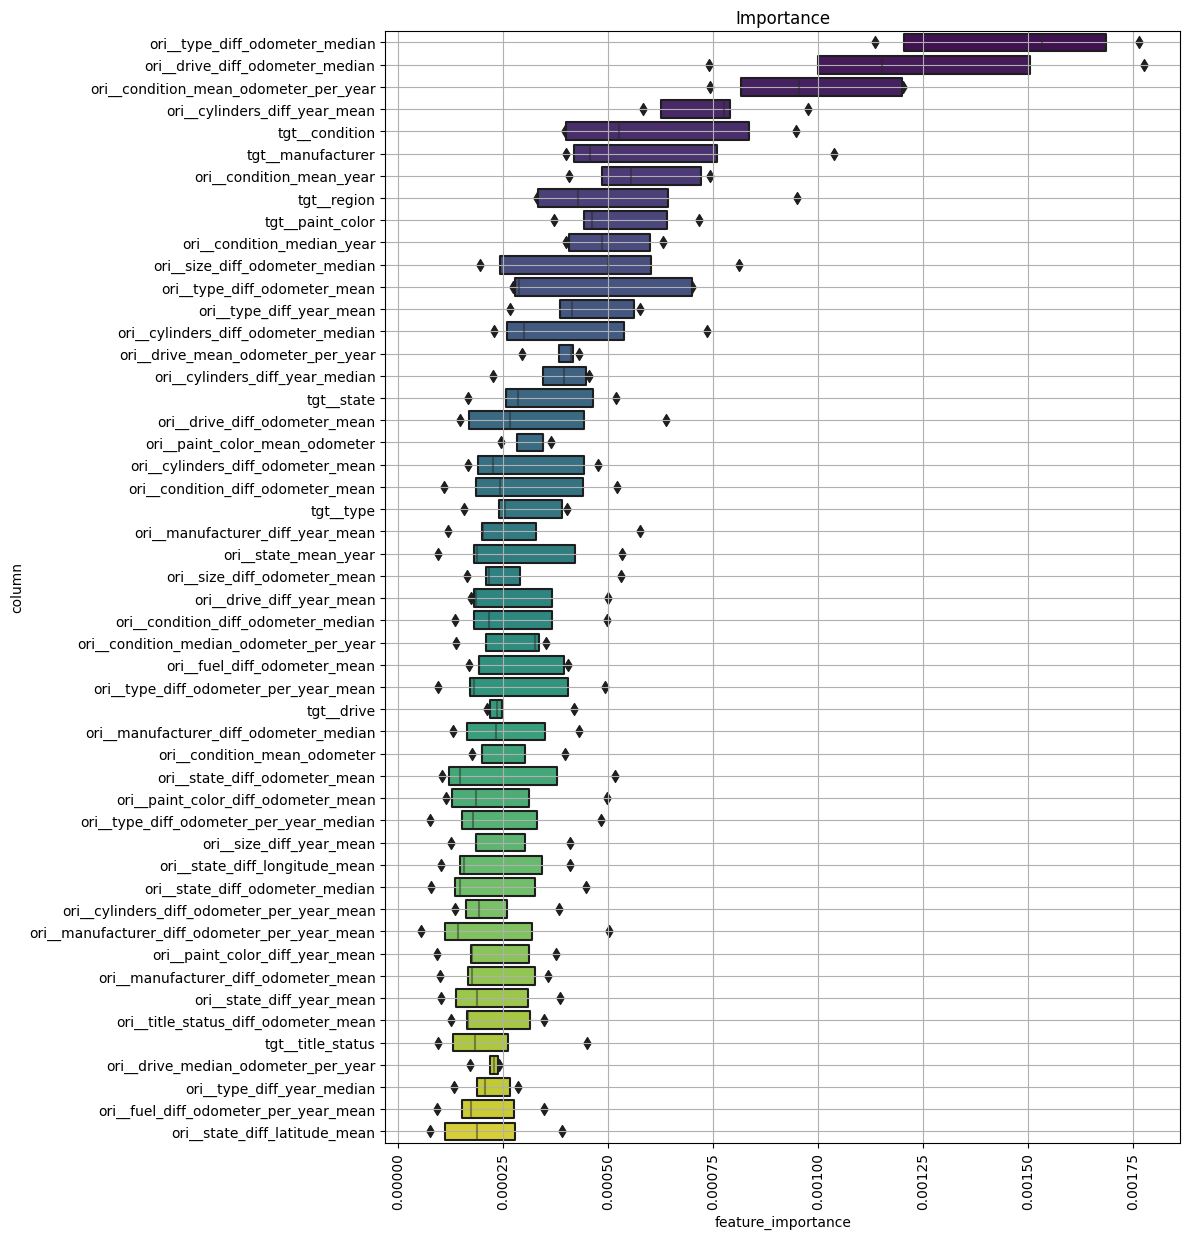

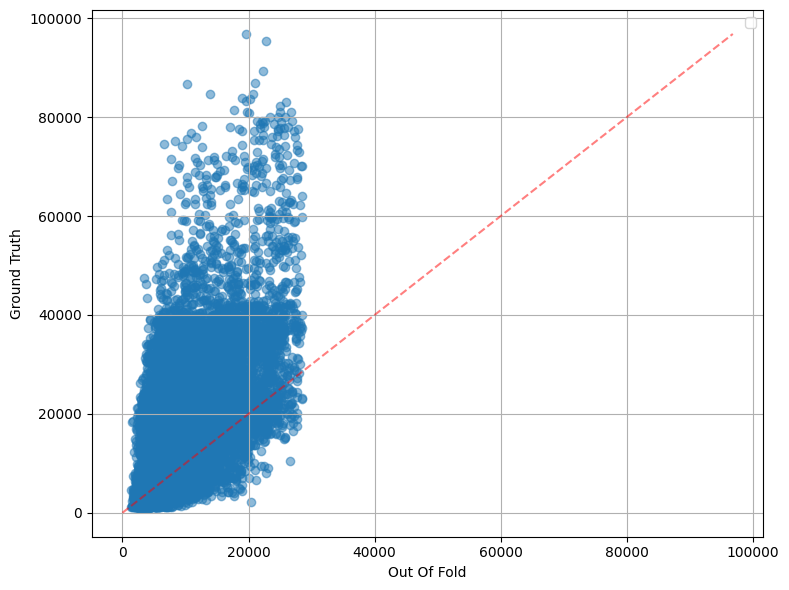

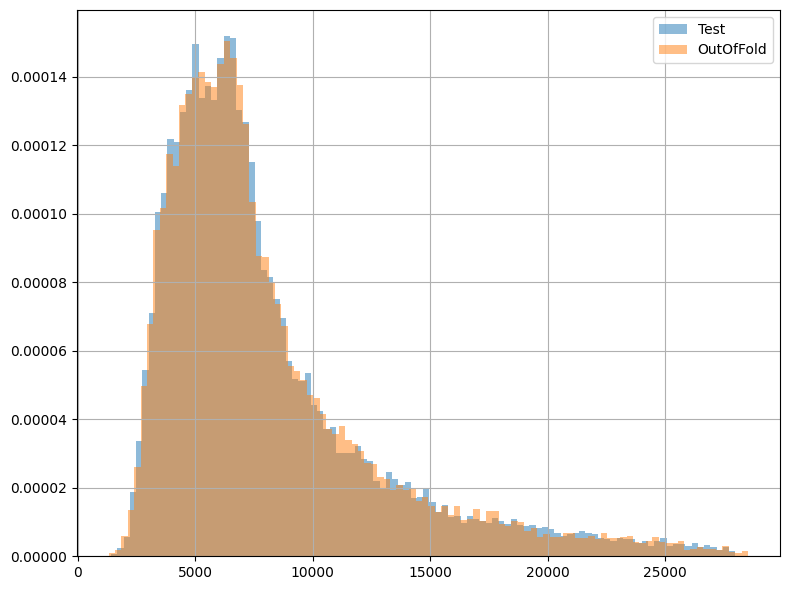

In [78]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

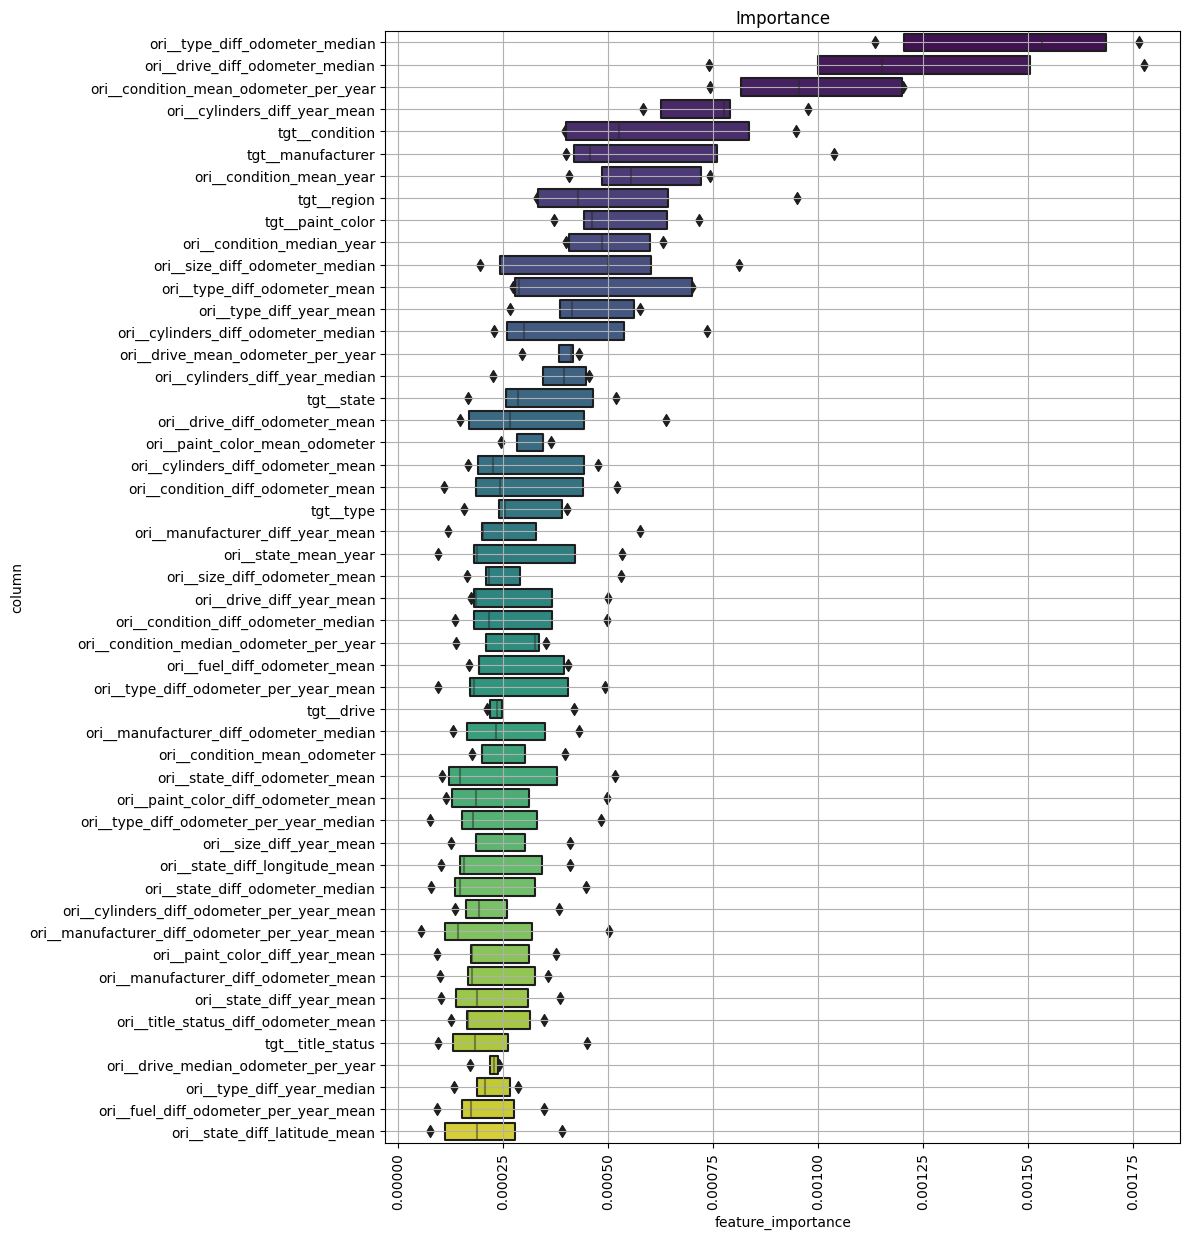

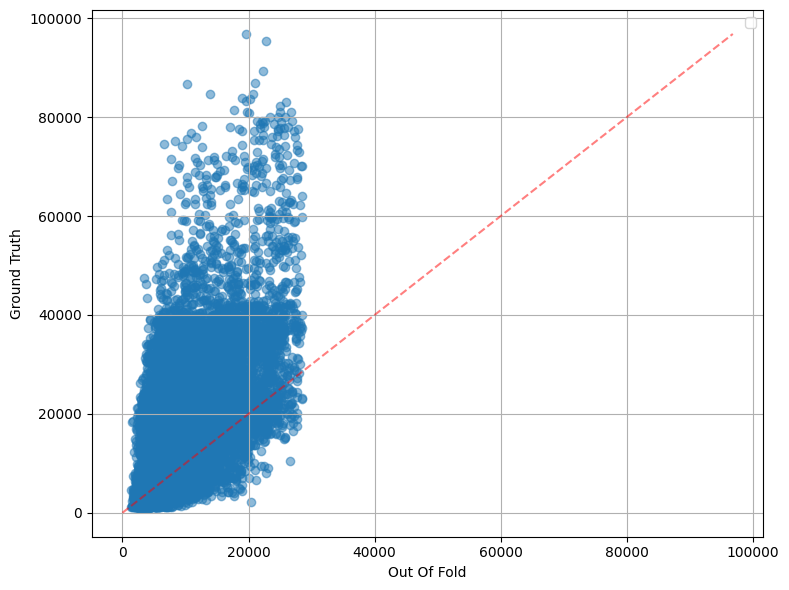

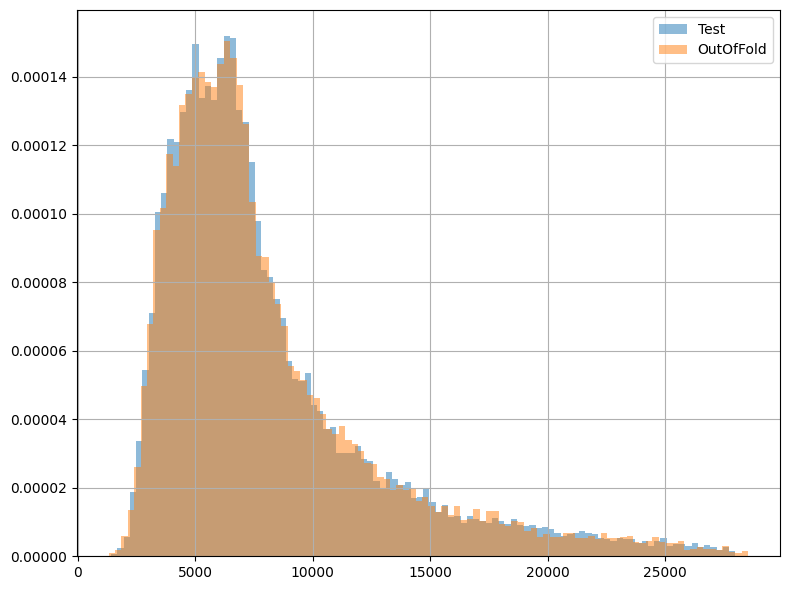

In [79]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [80]:
df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [81]:
train_df.isnull().sum()

id                               0
region                           0
year                             0
manufacturer                     0
condition                        0
                              ... 
state_diff_year_median           4
state_diff_latitude_mean       613
state_diff_latitude_median     613
state_diff_longitude_mean      613
state_diff_longitude_median    613
Length: 242, dtype: int64

In [82]:
test_df.isnull().sum()

id                               0
region                           0
year                             0
manufacturer                     0
condition                        0
                              ... 
state_diff_year_median           0
state_diff_latitude_mean       462
state_diff_latitude_median     462
state_diff_longitude_mean      462
state_diff_longitude_median    462
Length: 241, dtype: int64

In [83]:
train_df[train_df['odometer'] < 0]['odometer'].sum()

-265

In [84]:
train_feat_df.to_csv('train_feat_df.csv')

In [85]:
test_feat_df.to_csv('test_feat_df.csv')